In [5]:
%load_ext watermark
%watermark -a 'Michael Pilosov' -u -d -v -p numpy,pandas,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Michael Pilosov 
last updated: 2017-02-13 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.17.1


In [3]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Table of Contents
- [Overview](#Overview-Neural-Nets)
    - [Implementing A Perceptron](#Implementing-a-Perceptron)
  - [Training the Model on the Iris dataset](#Training-the-Model-on-the-Iris-dataset)
  - [Training the Perceptron Model](#Training-the-Perceptron-Model)
- [Code for Plotting Decision Regions](#Plotting-Decision-Regions)
- [Adaptive Linear Neurons](#Adaptive-Linear-Neurons)
    - [Minimizing Cost Functions with Gradient Descent](#Minimizing-cost-functions-with-gradient-descent)
- [Scaling with Data: Stochastic Gradient Descent](#Scaling-with-Data:-Stochastic-Gradient-Descent)
- [Summary](#Summary)
- [Appendix - Logistic Regression](#Appendix)

---

# Overview - Neural Nets

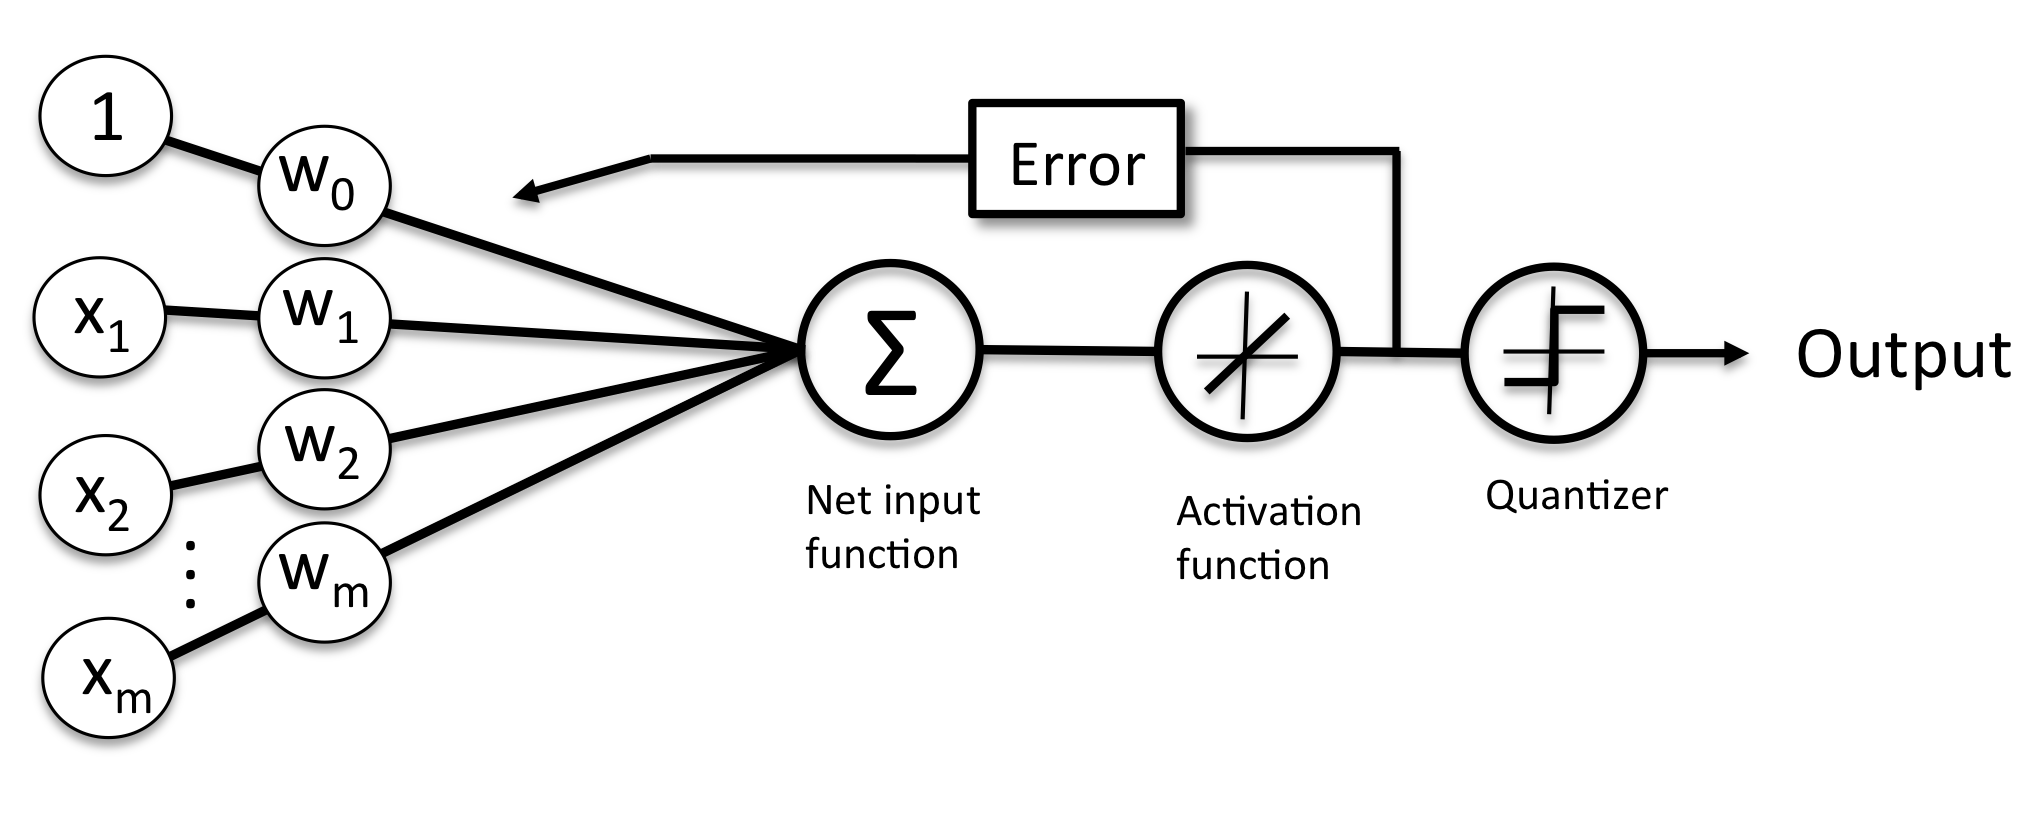

In [3]:
 Image(filename='./images/02_09.png', width=600)

Taking the activation function to be $y=x$, this network becomes identical to the (non-adaptaptive) perceptron model.
These neural nets are used for drawing decision boundaries and will (always?) find one for linearly separable data sets.

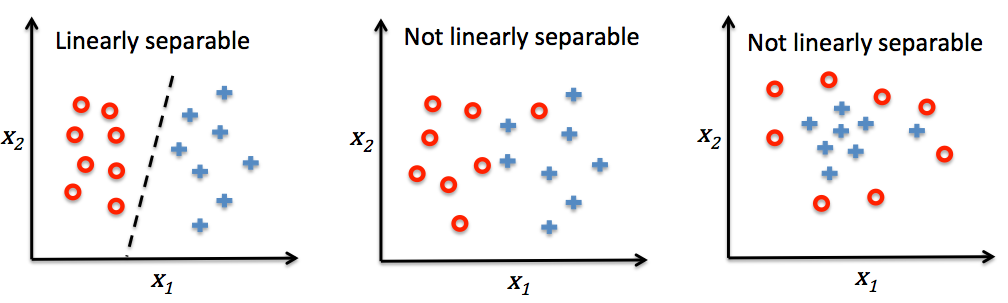

In [10]:
Image(filename='./images/02_03.png', width=600) 

## Implementing a Perceptron

Below, we implement the basic Perceptron algorithm with some slight modifications (adding random seed, initializing weights to random vector instead of zero). 
_Note that the learning rate $\eta$ only affects the algorithm's performance if weights are initialized to be nonzero._  
We also add on code from Raschka borrowed from a later algorithm that performs shuffling on the data set. These lines are denoted with `##` as a comment, as are the ones for random weights.

In [4]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, 
                 random_seed = 1, shuffle=True, random_state=None): ##
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle                     ##
        self.random_seed = random_seed             ##
        if random_state:                           ##
            np.random.seed(random_state)           ##
    
    def _shuffle(self, X, y):                      ##
        """Function to shuffle training data"""    ##
        r = np.random.permutation(len(y))          ##
        return X[r], y[r]                          ##
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
#         self.w_ = np.zeros(1 + X.shape[1])       # initialize weights to be zero
        rgen = np.random.RandomState(self.random_seed) ##
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) # initialize weights to be random.
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            if self.shuffle is True:              ##
                X, y = self._shuffle(X, y)        ##
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0] # we add the bias back on instead of padding our matrix with 1's

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Training the Model on the Iris dataset
We follow Raschka's example

In [13]:
# remote copy of dataset:
# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
# local copy for when internet connection is unavailable:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/iris/iris.data', header=None)
# df.values

In [7]:
# import cufflinks as cf
# cf.go_offline()
# df.iplot()

### Plotting the data

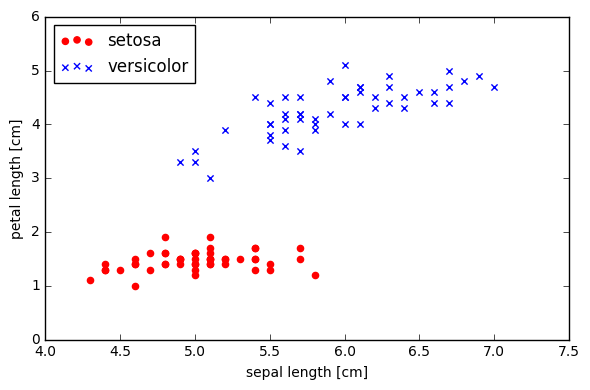

In [10]:
# # select setosa and versicolor with [0:100]
# drange = 0:100
# # y = df.iloc[drange, 4].values
# y = df.iloc[drange:, 4].values
# y = np.where(y == 'Iris-versicolor', 1, -1)

# # extract sepal length and petal length
# X = df.iloc[drange, [0, 2]].values

# plot data
# plt.scatter(X[0:max(drange)/2, 0], X[0:max(drange)/2, 1],
#             color='red', marker='o', label='setosa')
# plt.scatter(X[(1+max(drange)), 0], X[50:100, 1],
#             color='blue', marker='x', label='versicolor')

# # plt.xlabel('sepal length [cm]')
# # plt.ylabel('petal length [cm]')
# # plt.legend(loc='upper left')

# # plt.tight_layout()
# #plt.savefig('./images/02_06.png', dpi=300)
# # plt.show()

### Plotting Decision Regions

In [34]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

### Training the Perceptron Model

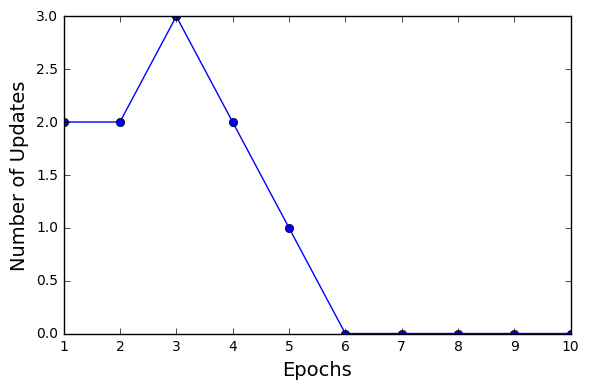

In [43]:
ppn = Perceptron(eta=0.1, n_iter=10, random_seed=0, shuffle=False) # trigger shuffling to see impact
label_size = 14
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs', fontsize=label_size)
plt.ylabel('Number of Updates', fontsize=label_size)

plt.tight_layout()
# plt.savefig('./perceptron_1.png', dpi=300)
plt.show()

We find the learning rate has quite an effect on the performance:

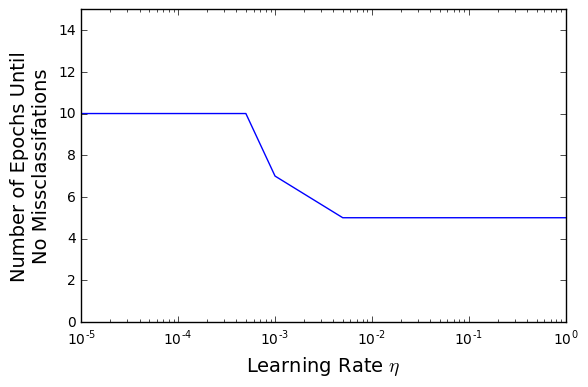

In [85]:
epochs_until_conv = []
eta_values = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1]
seed = 10         # play around with seed to demonstrate variability

for eta in eta_values:
    ppn = Perceptron(eta, n_iter=10, random_seed=seed, shuffle=False) # trigger shuffling to see impact
    ppn.fit(X, y)
    epochs_until_conv.append( len(np.nonzero(ppn.errors_)[0]) )
plt.plot(eta_values, epochs_until_conv)
plt.xscale('log')
plt.ylim([0,15])
plt.ylabel('Number of Epochs Until\nNo Missclassifations', fontsize=label_size)
plt.xlabel('Learning Rate $\eta$', fontsize=label_size)
plt.tight_layout()
plt.show()

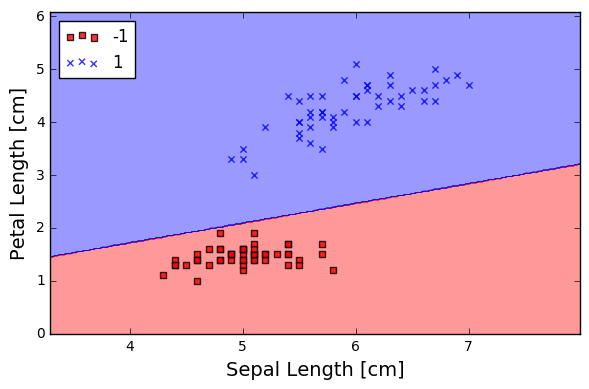

In [86]:
# Plot Decision Boundaries
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Sepal Length [cm]', fontsize=label_size)
plt.ylabel('Petal Length [cm]', fontsize=label_size)
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./perceptron_2.png', dpi=300)
plt.show()

# Adaptive Linear Neurons

## Minimizing cost functions with gradient descent
> One of the key ingredients of supervised machine learning algorithms is to de ne an objective function that is to be optimized during the learning process. This objective function is often a cost function that we want to minimize.

> In the case of Adaline, we can de ne the cost function J to learn the weights as the Sum of
Squared Errors (SSE) between the calculated outcome and the true class label
$$ J(w) = \frac{1}{2} \sum_i \left ( y^{(i)} - \phi( z^{(i)} ) \right )^2 $$

> The term $\frac{1}{2}$ is just added for our convenience; it will make it easier to derive the gradient, as we will see in the following paragraphs. The main advantage of this **continuous linear activation function** is—in contrast to the unit step function—that **the cost function becomes differentiable**. This cost function is *convex*; thus, we can use a simple, yet powerful, optimization algorithm called _gradient descent_ to find the weights that minimize our cost function to classify the samples in the Iris dataset.

> Using GD, we can now update the weights by taking a step away from the gradient $\nabla J(w)$ of our cost function $J(w)$:  
$$ w := w + \Delta w $$  
where we define the weight change $\Delta w$ as the negative gradient scaled by the learning rate:  
$$ \Delta w = -\eta \, \Delta J(w) $$  
and we have that 
$$ \frac{\partial J}{\partial w_j} = -\sum_i \left ( y^{(i)} - \phi( z^{(i)} ) \right ) \, x^{(i)}_j$$  
where $$\phi(z^{(i)}) = \sum_i \left ( w_j^{(i)}\, x_j^{(i)} \right )$$  
so we can rewrite $\Delta w_j$ as  
$$\large \Delta w_j = \eta \sum_i \left ( y^{(i)} - \phi( z^{(i)} ) \right ) \, x^{(i)}_j $$

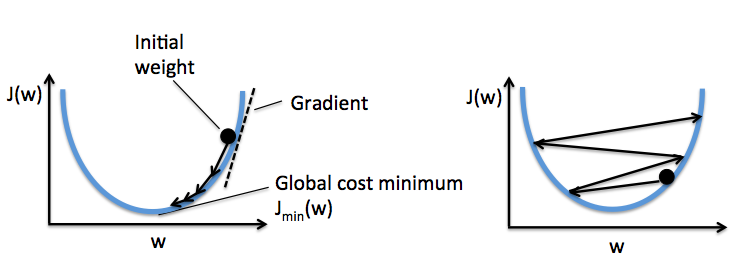

In [152]:
Image(filename='./images/02_12.png', width=700) 

We can see in the figure above that the learning rate corresponds to step-size in this search for a global minimum. Thus, taking too large a step can be disasterous, as seen on the right.

Here we implement the Stochastic Gradient Descent version of the Adaline algorithm (since batch size = $n$ would give you the original (non-stochastic) algorithm. 

> Inside the fit method, we will now update the weights after each training sample. Furthermore, we will implement an additional partial_fit method, which does not reinitialize the weights, for on-line learning. In order to check if our algorithm converged after training, we will calculate the cost as the average cost of the training samples in each epoch.

In [88]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value averaged over all
        training samples in each epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [90]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

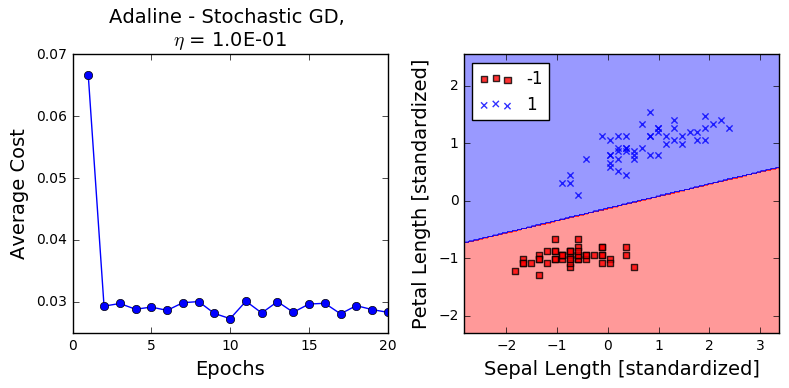

In [146]:
eta = 0.1   # play around with learning rate

ada = AdalineSGD(n_iter=20, eta=eta, shuffle=True, random_state=0)
ada.fit(X_std, y)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

plot_decision_regions(X_std, y, classifier=ada)
ax[1].set_xlabel('Sepal Length [standardized]', fontsize=label_size)
ax[1].set_ylabel('Petal Length [standardized]', fontsize=label_size)
plt.legend(loc='upper left')

ax[0].set_title('Adaline - Stochastic GD, \n$\eta$ = %1.1E'%eta, fontsize=label_size)
ax[0].plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
ax[0].set_xlabel('Epochs', fontsize=label_size)
ax[0].set_ylabel('Average Cost', fontsize=label_size)

plt.tight_layout()
plt.show()

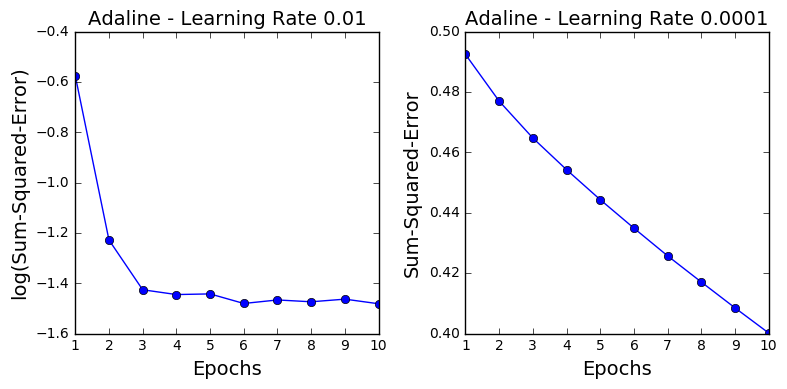

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineSGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs', fontsize=label_size)
ax[0].set_ylabel('log(Sum-Squared-Error)', fontsize=label_size)
ax[0].set_title('Adaline - Learning Rate 0.01', fontsize=label_size)

ada2 = AdalineSGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs', fontsize=label_size)
ax[1].set_ylabel('Sum-Squared-Error', fontsize=label_size)
ax[1].set_title('Adaline - Learning Rate 0.0001', fontsize=label_size)

plt.tight_layout()
# plt.savefig('./adaline_1.png', dpi=300)
plt.show()

# Scaling with Data: Stochastic Gradient Descent

Previously, we minimized our cost function by taking a step in the direction opposte the gradient computed using the whole training set. This is referred to as _batch_ gradient descent. This can be quite costly. We want to get an approximation of the true error through the use of a random sample.

Stochastic Gradient Descent updates the weights incrementally for each training sample:  

$$\large \Delta w  = \eta \, \left ( y^{(i)} - \phi( z^{(i)} ) \right ) \, x^{(i)} $$  

instead of the previous update strategy, which was given by  

$$\Delta w = \eta \sum_i \left ( y^{(i)} - \phi( z^{(i)} ) \right ) \, x^{(i)} $$

> Although stochastic gradient descent can be considered as an approximation of gradient descent, it typically reaches convergence much faster because of the more frequent weight updates. Since each gradient is calculated based on a single training example, the error surface is noisier than in gradient descent, which can also have the advantage that stochastic gradient descent can escape shallow local minima more readily.  

> To obtain accurate results via stochastic gradient descent, it is important to present it with data in a random order, which is why we want to shuf e the training set for every epoch to prevent cycles.
> The fixed learning rate $\eta$ is often replaced by an **adaptive learning rate** that decreases over time. For example, 
>   $$ \large \eta_k = \frac{c_1}{k + c_2}$$   
where $c_1, c_2$ are constants and $k$ is the number of iterations. 

> By using an adaptive learning rate, we can achieve further annealing to a better global minimum, since we cannot rely on SGD to reach the global minimum (rather an area nearby). 

> Another advantage of stochastic gradient descent is that we can use it for **online learning**. In online learning, _our model is trained on-the-fly_ as new training data arrives. 

> This is especially useful if we are accumulating large amounts of data—for example, customer data in typical web applications. Using online learning, the system can immediately adapt to changes and the training data can be discarded after updating the model if storage space in an issue.

> > A compromise between batch gradient descent and stochastic gradient descent is the so-called mini-batch learning. Mini-batch learning can be understood as applying batch gradient descent to smaller subsets of the training data—for example, 50 samples at a time.  

> > The advantage over batch gradient descent is that convergence is reached faster via mini-batches because of the more frequent weight updates. Furthermore, mini-batch learning allows us to replace the for-loop over the training samples in Stochastic Gradient Descent (SGD) by vectorized operations, which can further improve the computational ef ciency of our learning algorithm.

# Summary
> In this chapter, we gained a good understanding of the basic concepts of linear classi ers for supervised learning. After we implemented a perceptron, we saw how we can train adaptive linear neurons ef ciently via a vectorized implementation
of gradient descent and on-line learning via stochastic gradient descent. Now that we have seen how to implement simple classi ers in Python, we are ready to move on to the next chapter where we will use the Python scikit-learn machine learning library to get access to more advanced and powerful off-the-shelf machine learning classi ers that are commonly used in academia as well as in industry.

# Appendix
> The code below (not in the book) is a simplified, example implementation of a logistic regression classifier trained via gradient descent. The AdalineGD classifier was used as template and I commented the respective lines that were changed to turn it into a logistic regression classifier (as briefly mentioned in the "logistic regression" sections of Chapter 3).


In [147]:
class LogisticRegressionGD(object):
    """Logistic regression classifier via gradient descent.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        # We use the more common convention for logistic
        # regression returning class labels 0 and 1
        # instead of -1 and 1. Also, the threshold then
        # changes from 0.0 to 0.5 
        return np.where(self.activation(X) >= 0.5, 1, 0)
    
    # The Content of `activation` changed 
    # from linear (Adaline) to sigmoid.
    # Note that this method is now returning the
    # probability of the positive class
    # also "predict_proba" in scikit-learn
    def activation(self, X):
        """ Compute sigmoid activation."""
        z = self.net_input(X)
        sigmoid = 1.0 / (1.0 + np.exp(-z))
        return sigmoid

In [148]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:100, [0, 2]], iris.target[:100]

X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

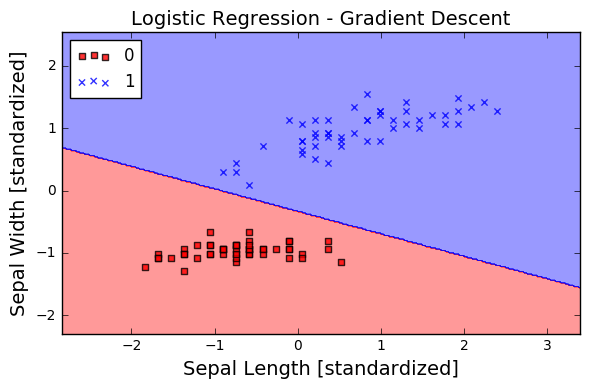

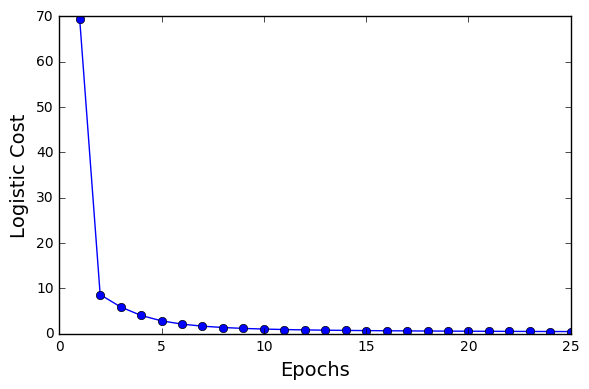

In [150]:
lr = LogisticRegressionGD(n_iter=25, eta=0.15)
lr.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=lr)
plt.title('Logistic Regression - Gradient Descent', fontsize=label_size)
plt.xlabel('Sepal Length [standardized]', fontsize=label_size)
plt.ylabel('Sepal Width [standardized]', fontsize=label_size)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

plt.plot(range(1, len(lr.cost_) + 1), lr.cost_, marker='o')
plt.xlabel('Epochs', fontsize=label_size)
plt.ylabel('Logistic Cost', fontsize=label_size)

plt.tight_layout()
# plt.savefig('./adaline_3.png', dpi=300)
plt.show()